In [2]:
%load_ext autoreload
%autoreload 2

In [3]:


# Imports for most of the notebook
import pandas
import torch
import numpy as np
import spacy
from typing import Dict, List, Optional, Tuple
from util import load_training_data

In [4]:
train_arg_path = "../data/arguments-training.tsv"
train_label_path = "../data/labels-training.tsv"
validation_arg_path = "../data/arguments-validation.tsv"
validation_label_path = "../data/labels-validation.tsv"

In [5]:
df_train_arguments, df_train_labels = load_training_data(train_arg_path, train_label_path)

df_train_labels = df_train_labels[["Argument ID", "Self-direction: action"]]
df_train_arguments = df_train_arguments.merge(df_train_labels, on='Argument ID')
df_train_arguments.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: action
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0
1,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0
2,A01003,We should abandon marriage,against,marriage is the ultimate commitment to someone...,1
3,A01004,We should ban naturopathy,against,it provides a useful income for some people,0
4,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0


In [6]:
df_vali_arguments, df_vali_labels = load_training_data(validation_arg_path, validation_label_path)

df_vali_labels = df_vali_labels[["Argument ID", "Self-direction: action"]]
df_vali_arguments = df_vali_arguments.merge(df_vali_labels, on='Argument ID')
df_vali_arguments.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: action
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,1
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and,0


In [7]:
def generate_input(dataset: pandas.core.frame.DataFrame) -> List[str]:
    
    premise, conclusion, label = ([] for i in range(3))
    premise = dataset["Premise"].tolist()
    conclusion = (dataset["Stance"] + ": " + dataset["Conclusion"]).tolist()
    label = dataset["Self-direction: action"].tolist()
        
    #return premise, conclusion, label
    return premise, label

In [8]:
class Tokenizer:
    """Tokenizes and pads a batch of input sentences."""

    def __init__(self, pad_symbol: Optional[str] = "<PAD>"):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<PAD>".
        """
        self.pad_symbol = pad_symbol
        self.nlp = spacy.load("en_core_web_sm")
    
    def __call__(self, batch: List[str]) -> List[List[str]]:
        """Tokenizes each sentence in the batch, and pads them if necessary so
        that we have equal length sentences in the batch.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            List[List[str]]: A List of equal-length token Lists.
        """
        batch = self.tokenize(batch)
        batch = self.pad(batch)

        return batch

    def tokenize(self, sentences: List[str]) -> List[List[str]]:
        """Tokenizes the List of string sentences into a Lists of tokens using spacy tokenizer.

        Args:
            sentences (List[str]): The input sentence.

        Returns:
            List[str]: The tokenized version of the sentence.
        """
        tokens = []
        for sentence in sentences:
            doc = self.nlp(sentence)
            temp = ["<SOS>"]
            for t in doc:
                temp.append(t.text)
            temp.append("<EOS>")
            tokens.append(temp)
        return tokens

    def pad(self, batch: List[List[str]]) -> List[List[str]]:
        """Appends pad symbols to each tokenized sentence in the batch such that
        every List of tokens is the same length. This means that the max length sentence
        will not be padded.

        Args:
            batch (List[List[str]]): Batch of tokenized sentences.

        Returns:
            List[List[str]]: Batch of padded tokenized sentences. 
        """
        padded_batch = []
        
        maxlen = len(max(batch, key=len))

        for token_list in batch:
            padded_batch.append(token_list + [self.pad_symbol]*(maxlen-len(token_list)))

        return padded_batch

In [9]:
# create the vocabulary of the dataset: use both training and test sets here

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>']

train, _ = generate_input(df_train_arguments)
vali, _ = generate_input(df_vali_arguments)
all_data =  train + vali
tokenizer = Tokenizer()

tokenized_data = tokenizer.tokenize(all_data)
vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))

with open('../embeddings/vocab.txt', 'w', encoding="utf-8") as vf:
    vf.write('\n'.join(vocab))

In [10]:
# Not going to put embeddings into the github, added to .gitignore
vocab_path = "../embeddings/vocab.txt"
embeddings_path = "../embeddings/glove.6B.300d.txt"
def read_pretrained_embeddings() -> Tuple[Dict[str, int], torch.FloatTensor]:
    """Read the embeddings matrix and make a dict hashing each word.

    Note that we have provided the entire vocab for train and test, so that for practical purposes
    we can simply load those words in the vocab, rather than all 27B embeddings

    Args:
        embeddings_path (str): _description_
        vocab_path (str): _description_

    Returns:
        Tuple[Dict[str, int], torch.FloatTensor]: _description_
    """
    word2i = {}
    vectors = []
    
    with open(vocab_path, "r", encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()]) 
    
    print(f"Reading embeddings from {embeddings_path}...")
    with open(embeddings_path, "r", encoding='utf8') as f:
        i = 0
        for line in f:
            word, *weights = line.rstrip().split(" ")
            if word in vocab:
                word2i[word] = i
                vectors.append(torch.tensor([float(w) for w in weights], dtype=torch.float))
                i += 1
    return word2i, torch.stack(vectors)

def get_oovs(word2i: Dict[str, int]) -> List[str]:
    """Find the vocab items that do not exist in the glove embeddings (in word2i).
    Return the List of such (unique) words.

    Args:
        vocab_path: List of batches of sentences.
        word2i (Dict[str, int]): _description_

    Returns:
        List[str]: _description_
    """
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()])
    
    glove_and_vocab = set(word2i.keys())
    vocab_and_not_glove = vocab - glove_and_vocab
    return list(vocab_and_not_glove)

def intialize_new_embedding_weights(num_embeddings: int, dim: int) -> torch.FloatTensor:
    """xavier initialization for the embeddings of words in train, but not in gLove.

    Args:
        num_embeddings (int): _description_
        dim (int): _description_

    Returns:
        torch.FloatTensor: _description_
    """
    # Initialize a num_embeddings x dim matrix with xiavier initiialization
    #      That is, a normal distribution with mean 0 and standard deviation of dim^-0.5
    return torch.nn.init.xavier_normal_(torch.zeros([num_embeddings, dim], dtype=torch.float))

def update_embeddings(
    glove_word2i: Dict[str, int],
    glove_embeddings: torch.FloatTensor,
    oovs: List[str]
) -> Tuple[Dict[str, int], torch.FloatTensor]:
    # TODO: Add the oov words to the dict, assigning a new index to each

    # TODO: Concatenate a new row to embeddings for each oov
    #       initialize those new rows with `intialize_new_embedding_weights`

    # TODO: Return the tuple of the dictionary and the new embeddings matrix
    i: int = len(glove_word2i)
    for word in oovs:
        glove_word2i[word] = i
        i += 1
    
    return glove_word2i, torch.cat((glove_embeddings,intialize_new_embedding_weights(len(oovs),300)))

In [11]:
def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def chunk_multi(lst1, lst2, n):
    for i in range(0, len(lst1), n):
        yield lst1[i: i + n], lst2[i: i + n]

def make_batches(sequences: List[str], batch_size: int) -> List[List[str]]:
    """Yield batch_size chunks from sequences."""
    batches = []
    for i in range(0, len(sequences), batch_size):
        batches.append(sequences[i:i+batch_size])
    return batches

train_arguments, train_labels = generate_input(df_train_arguments)
dev_arguments, dev_labels = generate_input(df_vali_arguments)

# Set your preferred batch size
batch_size = 8
tokenizer = Tokenizer()

# We make batches now and use those.
batch_tokenized = []
# Note: Labels need to be batched in the same way to ensure
# We have train sentence and label batches lining up.
for batch in make_batches(train_arguments, batch_size):
    batch_tokenized.append(tokenizer(batch))


glove_word2i, glove_embeddings = read_pretrained_embeddings()

# Find the out-of-vocabularies
oovs = get_oovs(glove_word2i)

# Add the oovs from training data to the word2i encoding, and as new rows
# to the embeddings matrix
word2i, embeddings = update_embeddings(glove_word2i, glove_embeddings, oovs)

Reading embeddings from ../embeddings/glove.6B.300d.txt...


In [12]:
def encode_sentences(batch: List[List[str]], word2i: Dict[str, int]) -> torch.LongTensor:
    """Encode the tokens in each sentence in the batch with a dictionary

    Args:
        batch (List[List[str]]): The padded and tokenized batch of sentences.
        word2i (Dict[str, int]): The encoding dictionary.

    Returns:
        torch.LongTensor: The tensor of encoded sentences.
    """
    UNK_IDX = word2i["<UNK>"]
    tensors = []
    for sent in batch:
        tensors.append(torch.LongTensor([word2i.get(w, UNK_IDX) for w in sent]))
        
    return torch.stack(tensors)


def encode_labels(labels: List[int]) -> torch.FloatTensor:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[int]): List of all labels in the batch

    Returns:
        torch.FloatTensor: Tensor of all labels in the batch
    """
    return torch.LongTensor([int(l) for l in labels])

In [13]:
import numpy as np
from numpy import logical_and, sum as t_sum

def precision(predicted_labels, true_labels, which_label=1):
    """
    Precision is True Positives / All Positives Predictions
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(pred_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def recall(predicted_labels, true_labels, which_label=1):
    """
    Recall is True Positives / All Positive Labels
    """
    pred_which = np.array([pred == which_label for pred in predicted_labels])
    true_which = np.array([lab == which_label for lab in true_labels])
    denominator = t_sum(true_which)
    if denominator:
        return t_sum(logical_and(pred_which, true_which))/denominator
    else:
        return 0.


def f1_score(
    predicted_labels: List[int],
    true_labels: List[int],
    which_label: int
):
    """
    F1 score is the harmonic mean of precision and recall
    """
    P = precision(predicted_labels, true_labels, which_label=which_label)
    R = recall(predicted_labels, true_labels, which_label=which_label)
    if P and R:
        return 2*P*R/(P+R)
    else:
        return 0.


def macro_f1(
    predicted_labels: List[int],
    true_labels: List[int],
    possible_labels: List[int]
):
    scores = [f1_score(predicted_labels, true_labels, l) for l in possible_labels]
    # Macro, so we take the uniform avg.
    return sum(scores) / len(scores)

In [14]:
class Model(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embeddings, pad_idx, output_size, dropout_val = 0.3) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.pad_idx = pad_idx
        self.dropout_val = dropout_val
        self.output_size = output_size
        self.embeddings = torch.nn.Embedding.from_pretrained(embeddings=embeddings,freeze=True,padding_idx=pad_idx)
        # Dropout regularization
        # https://jmlr.org/papers/v15/srivastava14a.html
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_val, inplace=False)
        # Bidirectional 2-layer LSTM. Feel free to try different parameters.
        # https://colah.github.io/posts/2015-08-Understanding-LSTMs/
        self.lstm = torch.nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=2,
            dropout=dropout_val,
            batch_first=True,
            bidirectional=True,
        )
        # For classification over the final LSTM state.
        self.classifier = torch.nn.Linear(hidden_dim*2, self.output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=2)
    
    def encode_text(
        self,
        symbols: torch.Tensor
    ) -> torch.Tensor:
        """Encode the (batch of) sequence(s) of token symbols with an LSTM.
            Then, get the last (non-padded) hidden state for each symbol and return that.

        Args:
            symbols (torch.Tensor): The batch size x sequence length tensor of input tokens

        Returns:
            torch.Tensor: The final hiddens tate of the LSTM, which represents an encoding of
                the entire sentence
        """
        # First we get the embedding for each input symbol
        embedded = self.embeddings(symbols)
        embedded = self.dropout_layer(embedded)
        # Packs embedded source symbols into a PackedSequence.
        # This is an optimization when using padded sequences with an LSTM
        lens = (symbols != self.pad_idx).sum(dim=1).to("cpu")
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, lens, batch_first=True, enforce_sorted=False
        )
        # -> batch_size x seq_len x encoder_dim, (h0, c0).
        packed_outs, (H, C) = self.lstm(packed)
        encoded, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=self.pad_idx,
            total_length=None,
        )
        # Now we have the representation of eahc token encoded by the LSTM.
        encoded, (H, C) = self.lstm(embedded)
        
        # This part looks tricky. All we are doing is getting a tensor
        # That indexes the last non-PAD position in each tensor in the batch.
        last_enc_out_idxs = lens - 1
        # -> B x 1 x 1.
        last_enc_out_idxs = last_enc_out_idxs.view([encoded.size(0)] + [1, 1])
        # -> 1 x 1 x encoder_dim. This indexes the last non-padded dimension.
        last_enc_out_idxs = last_enc_out_idxs.expand(
            [-1, -1, encoded.size(-1)]
        )
        # Get the final hidden state in the LSTM
        last_hidden = torch.gather(encoded, 1, last_enc_out_idxs)
        return last_hidden
    
    def forward(
        self,
        symbols: torch.Tensor,
    ) -> torch.Tensor:
        encoded_sents = self.encode_text(symbols)
        output = self.classifier(encoded_sents)
        return self.log_softmax(output)

In [15]:
def predict(model: torch.nn.Module, sents: torch.Tensor) -> List:
    logits = model(sents)
    return list(torch.argmax(logits, axis=2).squeeze().numpy())

In [16]:
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt

def training_loop(
    num_epochs,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model,
):
    print("Training...")
    loss_func = torch.nn.NLLLoss()
    batches = list(zip(train_features, train_labels))
    random.shuffle(batches)
    loss_values = []
    f1_values = []
    for i in range(num_epochs):
        losses = []
        for features, labels in tqdm(batches):
            # Empty the dynamic computation graph
            optimizer.zero_grad()
            preds = torch.squeeze(model(features),1)
            #print(preds)
            #print(labels)
            loss = loss_func(preds, labels)
            # Backpropogate the loss through our model
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        loss_values.append(sum(losses)/len(losses))
        # Estimate the f1 score for the development set
        print("Evaluating dev...")
        all_preds = []
        all_labels = []
        for sents, labels in tqdm(zip(dev_features, dev_labels), total=len(dev_features)):
            pred = predict(model, sents)
            all_preds.extend(pred)
            all_labels.extend(list(labels.numpy()))

        dev_f1 = macro_f1(all_preds, all_labels, [0,1])
        f1_values.append(dev_f1)
        print(f"Dev F1 {dev_f1}")
    
    plt.figure(figsize=(6,4),dpi=200)
    plt.plot(f1_values,label='F1 Score', linewidth=0.5)
    plt.plot(loss_values, label='Loss', linewidth=0.5)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    # Return the trained model
    return model

Training...


C:\Users\Robert\AppData\Local\Temp\ipykernel_8296\2111951105.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for features, labels in tqdm(batches):


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 0, loss: 0.5191341813476856
Evaluating dev...


C:\Users\Robert\AppData\Local\Temp\ipykernel_8296\2111951105.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sents, labels in tqdm(zip(dev_features, dev_labels), total=len(dev_features)):


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.6685451829829459


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 1, loss: 0.47020010154973857
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.6854735150492323


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 2, loss: 0.4392259304866674
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.6804166477418965


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 3, loss: 0.41491958662114503
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7204693349728585


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 4, loss: 0.38694118745168626
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7237531161638977


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 5, loss: 0.3534021833269739
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7543023014721129


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 6, loss: 0.31684377056419577
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.7879597761074212


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 7, loss: 0.27059690747695303
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8036593219175159


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 8, loss: 0.22936107191096017
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8065376362166778


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 9, loss: 0.18874602622294065
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.807570224263543


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 10, loss: 0.15582160449873478
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8284427966101694


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 11, loss: 0.1304146374808357
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.838902573820271


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 12, loss: 0.1213085500063135
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8284427966101694


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 13, loss: 0.09783142283989386
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8477597559017183


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 14, loss: 0.0933181566454468
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8360386195770758


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 15, loss: 0.07848460703343813
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.827413221134396


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 16, loss: 0.06802609432822505
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8543278840033183


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 17, loss: 0.05700871135389361
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8435818835063591


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 18, loss: 0.058067042908696694
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.855324603973995


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 19, loss: 0.06294935685941243
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8461800510380048


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 20, loss: 0.052161483285566405
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8383053487655998


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 21, loss: 0.04765529717476222
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8500671421324342


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 22, loss: 0.04942186906501951
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8403021755365843


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 23, loss: 0.04970746442807427
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8431985051850638


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 24, loss: 0.044187601046335144
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8603504120044815


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 25, loss: 0.03185104769615351
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8610513973031073


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 26, loss: 0.04169459762512215
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8494783445146015


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 27, loss: 0.043597466843906016
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8655329403421006


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 28, loss: 0.03475191046078991
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.8707851143981882


  0%|          | 0/653 [00:00<?, ?it/s]

epoch 29, loss: 0.03265974052588846
Evaluating dev...


  0%|          | 0/237 [00:00<?, ?it/s]

Dev F1 0.854603066180935


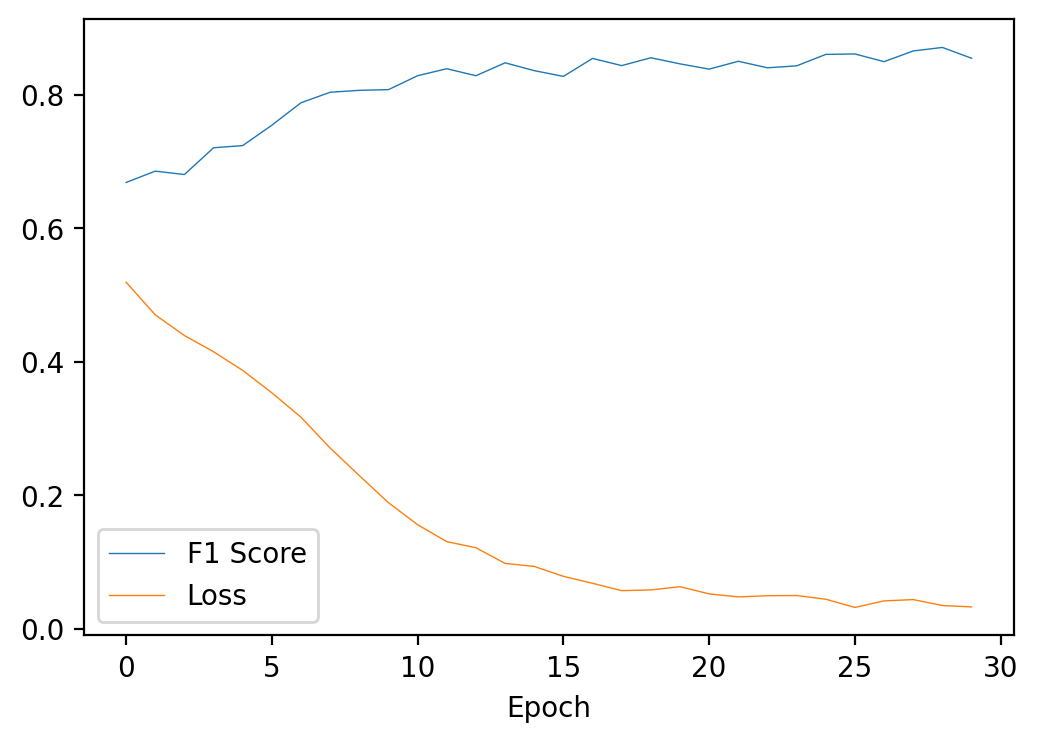

In [17]:
model = Model(300, 200, embeddings, word2i["<PAD>"], 2)

tokenizer = Tokenizer()
batch_size = 8

train_args, train_labels = generate_input(df_train_arguments)
train_input_batches = [b for b in chunk(train_args, batch_size)]
train_label_batches = [b for b in chunk(train_labels, batch_size)]
# Tokenize + encode
train_input_batches = [tokenizer(batch) for batch in train_input_batches]

# Validation dataset
vali_args, vali_labels = generate_input(df_vali_arguments)
vali_input_batches = [b for b in chunk(vali_args, batch_size)]
vali_label_batches = [b for b in chunk(vali_labels, batch_size)]
# Tokenize + encode
vali_input_batches = [tokenizer(batch) for batch in vali_input_batches]

encoded_train_args = [encode_sentences(batch, word2i) for batch in train_input_batches]
encoded_dev_args = [encode_sentences(batch, word2i) for batch in vali_input_batches]
encoded_train_labels = [encode_labels(batch) for batch in train_label_batches]
encoded_dev_labels = [encode_labels(batch) for batch in vali_label_batches]

num_epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

model = training_loop(
    num_epochs,
    encoded_train_args,
    encoded_train_labels,
    encoded_dev_args,
    encoded_dev_labels,
    optimizer,
    model
)

In [18]:
"""
##### TEST 1:
loss: 0.16, F1: 0.82, 30 epochs, 8 batch size, 0.001 LR, 100x65 dim
##### TEST 2:
loss: 0.35, F1: 0.72, 30 epochs, 8 batch size, 0.001 LR, 50x65 dim
##### TEST 3:
loss: 0.05, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 200x120 dim
##### TEST 4:
loss: 0.03, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 300x200 dim

##### TEST 5:
loss: 0.02, F1: 0.85, 30 epochs, 16 batch size, 0.001 LR, 300x200 dim
##### TEST 6:
loss: 0.03, F1: 0.87, 30 epochs, 8 batch size, 0.0005 LR, 300x200 dim
##### TEST 7:
loss: 0.04, F1: 0.83, 30 epochs, 16 batch size, 0.0005 LR, 300x200 dim
##### TEST 8:
loss: 0.03, F1: 0.87, 30 epochs, 32 batch size, 0.001 LR, 300x200 dim
##### TEST 9:
loss: 0.03, F1: 0.85, 30 epochs, 48 batch size, 0.001 LR, 300x200 dim

##### TEST 10:
loss: 0.01, F1: 0.86, 50 epochs, 32 batch size, 0.001 LR, 300x200 dim
"""

'\n##### TEST 1:\nloss: 0.16, F1: 0.82, 30 epochs, 8 batch size, 0.001 LR, 100x65 dim\n##### TEST 2:\nloss: 0.35, F1: 0.72, 30 epochs, 8 batch size, 0.001 LR, 50x65 dim\n##### TEST 3:\nloss: 0.05, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 200x120 dim\n##### TEST 4:\nloss: 0.03, F1: 0.86, 30 epochs, 8 batch size, 0.001 LR, 300x200 dim\n\n##### TEST 5:\nloss: 0.02, F1: 0.85, 30 epochs, 16 batch size, 0.001 LR, 300x200 dim\n##### TEST 6:\nloss: 0.03, F1: 0.87, 30 epochs, 8 batch size, 0.0005 LR, 300x200 dim\n##### TEST 7:\nloss: 0.04, F1: 0.83, 30 epochs, 16 batch size, 0.0005 LR, 300x200 dim\n##### TEST 8:\nloss: 0.03, F1: 0.87, 30 epochs, 32 batch size, 0.001 LR, 300x200 dim\n##### TEST 9:\nloss: 0.03, F1: 0.85, 30 epochs, 48 batch size, 0.001 LR, 300x200 dim\n\n##### TEST 10:\nloss: 0.01, F1: 0.86, 50 epochs, 32 batch size, 0.001 LR, 300x200 dim\n'